# Optimization of Dimensionality Witness Nonlocality

### Goal: Optimize nonlocality against simple qubit dimensionality witnesses

### Background:

Dimensionality witnesses are Bell inequalities for bipartite prepare and measure scenarios (see [Device-Independent Tests of Classical and Quantum Dimensions](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.105.230501)).

<img src="images/dimensionality_witnessing_scenario.png" alt="dimensionality witnessing scenario" width="300"/>

In this setting, Alice and Bob receive independent inputs $x$ and $y$ respectively.
Alice encodes input $x$ into a quantum states $\rho_x$ which is then sent to Bob over a quantum channel.
Bob performs a measurent $\Pi_b^y$ conditioned on input $y$ to produce an output $b\in\{0,1\}$.
A simple Bell inequality with known quantum violations is expressed as:

$$I_3 \equiv |\langle B_{11}\rangle + \langle B_{12} \rangle + \langle B_{21} \rangle - \langle B_{22} \rangle - \langle B_{31} \rangle  | \leq 3$$

where $\langle B_{xy} \rangle = P(0|xy) - P(1|xy)$. The bound on the quantum score is $I_3 \leq 1 + 2\sqrt{2} \approx 3.8284$. 

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

### Setup Quantum Circuits

In [2]:
# The I_3 dimensionality witness only requires one qubit to simulate
dev = qml.device("default.qubit", wires=1)

# optimizer
opt = qml.GradientDescentOptimizer()

@qml.qnode(dev)
def real_I3_circuit(θ_state, θ_measurement):  
    """
    Ansatz circuit where states ρ_x and measurements Π_b^y are free to rotate about the y-axis.
    In this model, all quantum states real.

    Args:
        θ_state (float) : rotation angle on ρ_x
        θ_measurement (float) : rotation angle on Π_b^y
    """    
    qml.RY(θ_state, wires=0)
    qml.RY(θ_measurement, wires=0)
    
    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev)
def arbitrary_I3_circuit(state_params, measurement_params):
    """
    Ansatz circuit where states ρ_x are prepared with a single qubit `ArbitraryUnitary` gate and
    measurements Π_b^y are prepared with a single qubit `ArbitraryUnitary` gate.

    Args:
        state_params (list[float]) : 3 angle parameters for the arbitrary qubit state.
        measurement_params (list[float]) : 3 angle parameters for the arbitrary measurement.
    """
    qml.templates.subroutines.ArbitraryUnitary(state_params, [0])
    qml.templates.subroutines.ArbitraryUnitary(measurement_params, [0])
    return qml.expval(qml.PauliZ(0))

### Setup Cost Functions for the Optimization

In [3]:
def real_I3_cost(real_settings):
    """
    Evaluates the I3 inequality by running the `real_I3_circuit` with parameters specified
    by `real_settings`.
    
    Args:
        real_settings (list[float]) : 5-element list
    """
    B_11 = real_I3_circuit(real_settings[0], real_settings[3])
    B_12 = real_I3_circuit(real_settings[0], real_settings[4])
    B_21 = real_I3_circuit(real_settings[1], real_settings[3])
    B_22 = real_I3_circuit(real_settings[1], real_settings[4])
    B_31 = real_I3_circuit(real_settings[2], real_settings[3])
    return -(B_11 + B_12 + B_21 - B_22 - B_31)

def arbitrary_I3_cost(arb_settings):
    """
    Evaluates the I3 inequality by running the `arbitrary_I3_circuit` with parameters specified
    by `arb_settings`.
    
    Args:
        arb_settings (list[float]) : 15-element list
    """
    B_11 = arbitrary_I3_circuit(arb_settings[0:3], arb_settings[9:12])
    B_12 = arbitrary_I3_circuit(arb_settings[0:3], arb_settings[12:15])
    B_21 = arbitrary_I3_circuit(arb_settings[3:6], arb_settings[9:12])
    B_22 = arbitrary_I3_circuit(arb_settings[3:6], arb_settings[12:15])
    B_31 = arbitrary_I3_circuit(arb_settings[6:9], arb_settings[9:12])
    return -(B_11 + B_12 + B_21 - B_22 - B_31)

### Methods to Randomize Initial Parameters

In [4]:
def real_I3_rand_settings():
    """
    Returns a 5-element list with the randomized angles of the `real_I3_cost` method.
    """
    return 2*np.pi*np.random.random(5) - np.pi

def arbitrary_I3_rand_settings():
    """
    Returns a 15-element list with the randomized angles of the `arbitrary_I3_cost` method.
    """
    return 2*np.pi*np.random.random(15) - np.pi

### Optimizing $I_3$ Inequality over Real Parameter Space

In [5]:
# initial settings
real_settings = real_I3_rand_settings()
real_scores = []

# performing gradient descent
for i in range(500):
    real_settings = opt.step(real_I3_cost, real_settings)
    score = -(real_I3_cost(real_settings))
    real_scores.append(score)
    
    
    if i%50 == 0:
        print("iteration : ",i, ", cost : ", score)
        print("settings :\n", real_settings, "\n")


# printing final results    
print("final cost : ", real_I3_cost(real_settings),",")
print("final settings : ", real_settings)

iteration :  0 , cost :  -2.257935398635778
settings :
 [ 2.61242888 -1.33209434  2.02509076 -1.89675479 -0.04992808] 

iteration :  50 , cost :  0.9340983640757259
settings :
 [ 2.0572583  -1.98080486  2.00202382 -2.295779   -0.87785189] 

iteration :  100 , cost :  2.302811881176977
settings :
 [ 1.93908258 -2.39185009  1.70303587 -2.80802398 -1.19381583] 

iteration :  150 , cost :  3.165382433286932
settings :
 [ 2.03251401 -2.48426441  1.21983428 -3.21405302 -1.26997127] 

iteration :  200 , cost :  3.5397579657381093
settings :
 [ 2.1464277  -2.43722365  0.84581802 -3.36409984 -1.33298625] 

iteration :  250 , cost :  3.6863657488102226
settings :
 [ 2.2408583  -2.38038     0.61182616 -3.37528843 -1.40451528] 

iteration :  300 , cost :  3.756546385423555
settings :
 [ 2.31122731 -2.34072047  0.4595437  -3.35053501 -1.47152261] 

iteration :  350 , cost :  3.7921598577073414
settings :
 [ 2.36051202 -2.31446667  0.35544645 -3.324004   -1.52661236] 

iteration :  400 , cost :  3.8

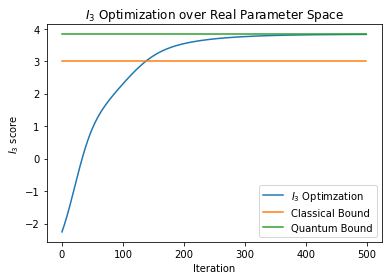

In [6]:
# Plot the individual observables
plt.plot(range(500), real_scores , label = r"$I_3$ Optimzation")
plt.plot(range(500), [3]*500, label = r"Classical Bound")
plt.plot(range(500), [1+2*np.sqrt(2)]*500, label = r"Quantum Bound")
plt.title(r"$I_3$ Optimization over Real Parameter Space")
plt.xlabel("Iteration")
plt.ylabel(r"$I_3$ score")
plt.legend()
plt.show()

### Optimize $I_3$ Inequality over Complex Parameter Space

In [7]:
# initial settings
arb_settings = arbitrary_I3_rand_settings()
arb_scores = []

# performing gradient descent
for i in range(500):
    arb_settings = opt.step(arbitrary_I3_cost, arb_settings)
    
    score = -(arbitrary_I3_cost(arb_settings))
    arb_scores.append(score)
    
    if i%50 == 0:
        print("iteration : ",i, ", score : ", score)
        print("settings :\n", arb_settings, "\n")

# printing final results    
print("final score : ", arbitrary_I3_cost(arb_settings),",")
print("final settings : ", arb_settings)

iteration :  0 , score :  -2.996041889170079
settings :
 [-0.80854079 -0.16679727 -0.84554038 -0.08353517 -2.1372791  -0.63545046
 -0.82907927 -2.55182114 -2.81219945  0.71560766 -2.35118387  0.82202108
 -0.68915656  2.73422698  2.015667  ] 

iteration :  50 , score :  -0.18338279572574212
settings :
 [-1.42151795 -0.19675618 -0.89404485  0.03431564 -2.58108396 -0.56794493
 -0.96877365 -2.66116779 -3.00064095  0.35116251 -2.0418365   0.82202108
 -1.15579949  3.24049093  2.015667  ] 

iteration :  100 , score :  2.305503209239976
settings :
 [-1.70610993 -0.19870043 -0.9368508   0.32148985 -3.04880035 -0.40416063
 -1.28951016 -2.80136943 -3.38900683  0.00933535 -2.08478948  0.82202108
 -1.60905022  3.67893043  2.015667  ] 

iteration :  150 , score :  3.3517672867964334
settings :
 [-1.77076287 -0.19912357 -0.95315421  0.45769533 -3.26816632 -0.31429051
 -1.67196021 -2.82853789 -3.74572547 -0.24460821 -2.23507184  0.82202108
 -1.84697573  3.77078386  2.015667  ] 

iteration :  200 , sco

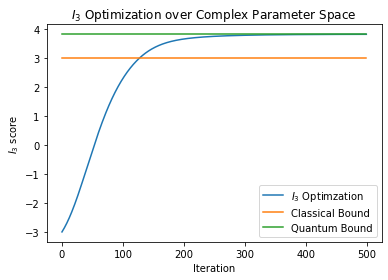

In [8]:
# Plot the individual observables
plt.plot(range(500), arb_scores , label = r"$I_3$ Optimzation")
plt.plot(range(500), [3]*500, label = r"Classical Bound")
plt.plot(range(500), [1+2*np.sqrt(2)]*500, label = r"Quantum Bound")
plt.title(r"$I_3$ Optimization over Complex Parameter Space")
plt.xlabel("Iteration")
plt.ylabel(r"$I_3$ score")
plt.legend()
plt.show()